### Step 1: Importing the dependencies

In [1]:
import pandas as pd
import re
import pickle
import tensorflow as tf
import tensorflow_text as text
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from tensorflow.keras.layers import TextVectorization
import string
from nltk.tokenize import word_tokenize

# Download NLTK resources (stopwords and WordNet)
import nltk
nltk.download('stopwords')

2024-02-04 13:13:13.977407: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 13:13:14.014917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 13:13:14.014973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 13:13:14.016190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 13:13:14.022394: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 13:13:14.022844: I tensorflow/core/platform/cpu_feature_guard.cc:1

True

### Defining Parameters

In [2]:
# Shuffle and batch the dataset
batch_size = 32
seed = 42

# Vocabulary size and number of words in a sequence
vocab_size = 10000
sequence_length = 100

stop_words = tf.constant(stopwords.words('english'))

### Step 2: Creation of Questions dataframe
Currently there are 5 different files belonging to 5 different domain of the questions and in this module we will be creating a dataframe that will be having total of 1600 questions belonging to 5 different domains. The domains are 
- DSA questions
- System design questions
- AI questions
- Computer fundamental questions
- Behavioural questions

In [3]:
file_paths = ['../Dataset/DSA_que.txt', '../Dataset/System_Design_que.txt', '../Dataset/Behavioural_que.txt',
              '../Dataset/CS_fundamentals.txt', '../Dataset/AI_que.txt']
que_type = {0: 'DSA',
            1: 'System_design',
            2: 'Behavioural',
            3: 'CS_fundamentals',
            4: 'AI'}
count = 0
df = pd.DataFrame()

# Going over all the paths
for paths in file_paths:
    try:
        # Reset que_ls for each file iteration
        que_ls = []

        with open(paths, 'r') as file:
            lines = file.readlines()
            for line in lines:
                
                # Removing the leading and following white space after reading content from the file
                line = line.strip()
                
                # Saving the line in the que list
                que_ls.append(line)

            # Creating series from the 
            que_sr = pd.Series(que_ls)
            temp_df = pd.DataFrame({'Que': que_sr})

            # Adding a feature 'Category'
            temp_df['Category'] = que_type[count]
            count = count + 1

            # Concatenating the dataframes
            df = pd.concat([df, temp_df], axis=0)

    except FileNotFoundError:
        print(f"The file {paths} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [4]:
# Shuffling the dataframe
df = df.sample(frac=1, random_state=42)

# Resetting the index
df.reset_index(drop=True,inplace=True)

In [5]:
# Saving the dataframe
# df.to_csv('../Dataset/Que_Classification.csv')

### Exploratory data analysis
In this module our aim will be derive some useful insights from the questions belonging to differet domains and this analysis will further help us to decide what type of feature engineering we will do.

In [6]:
# Checking any 5 random rows from the dataframe
df = pd.read_csv('../Dataset/Que_Classification.csv')
df.drop(['Unnamed: 0'],inplace=True,axis=1)
df.sample(5)

,Que,Category
1003,Explain the concept of a disjoint-set data str...,DSA
303,What factors influence your decision on using ...,System_design
455,How does the Dijkstra's algorithm handle graph...,DSA
12,"Define the term ""preprocessing"" in the context...",AI
120,What is the purpose of the OSI model's Physica...,CS_fundamentals


In [7]:
# Checking percentage of missinng values
df.isnull().mean()*100

Que         0.0
Category    0.0
dtype: float64

In [8]:
# Checking if there are any duplicate values
duplicate_counts = df.duplicated().sum()
if duplicate_counts > 0:

    # Storing all the duplicate data
    Duplicate_df = df[df.duplicated() == True]
    print("Duplicate values found and stored in dataframe, dataframe size : ",Duplicate_df.shape[0])
else:
    print("There are no duplicate values")

Duplicate values found and stored in dataframe, dataframe size :  736


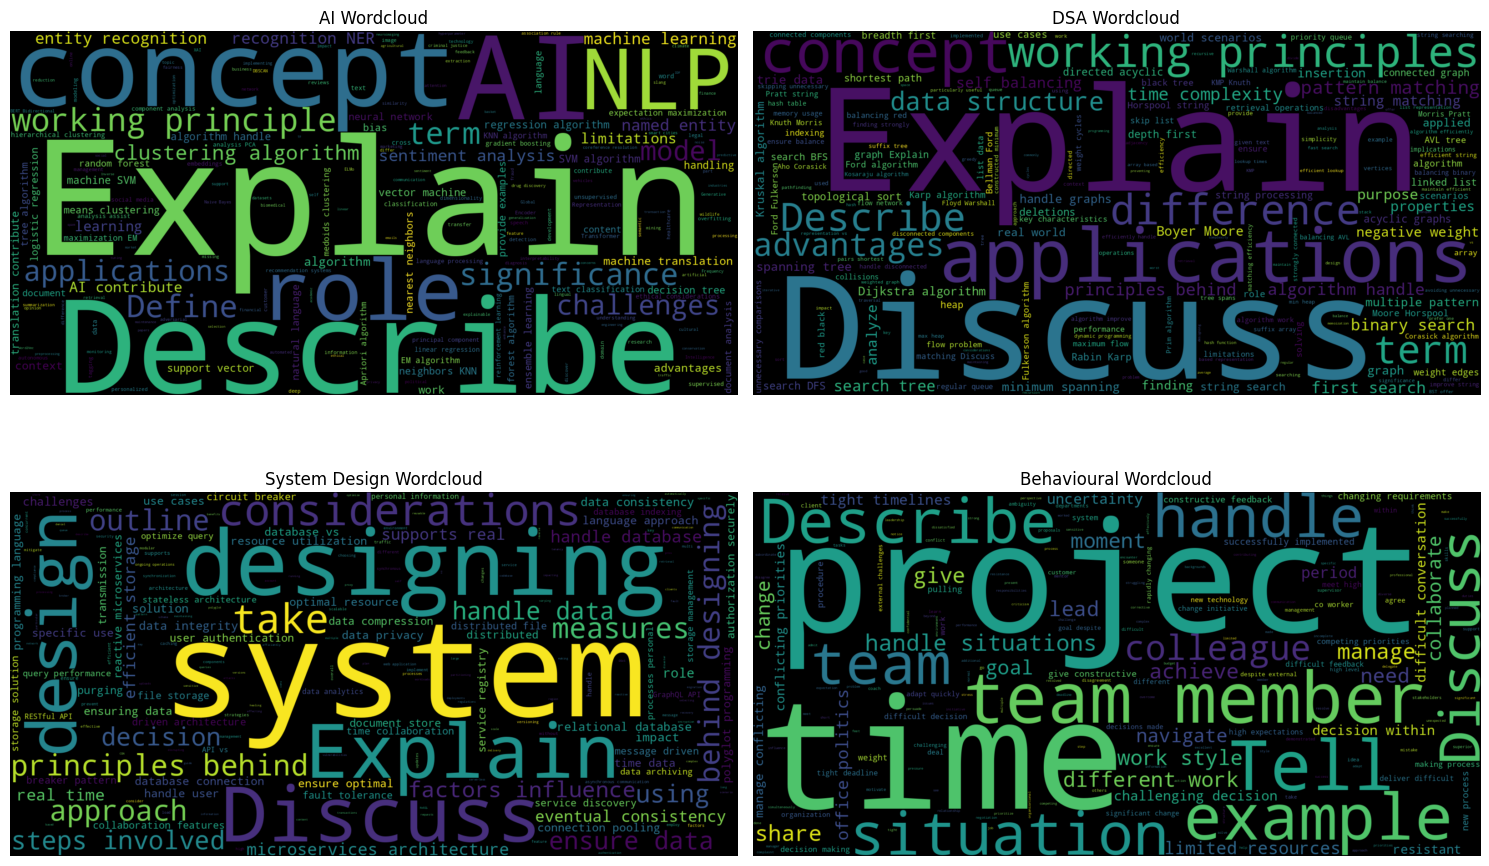

In [9]:
# Extracting the course titles and joining sentences into a single string
ai_que = df[df['Category'] == 'AI']['Que'].values
dsa_que = df[df['Category'] == 'DSA']['Que'].values
sd_que = df[df['Category'] == 'System_design']['Que'].values
beh_que = df[df['Category'] == 'Behavioural']['Que'].values

# Extracting all the questions into single string
ai_que_string = " ".join(ai_que.tolist())  
dsa_que_string = " ".join(dsa_que.tolist())  
sd_que_string = " ".join(sd_que.tolist())  
beh_que_string = " ".join(beh_que.tolist())  

# Set other parameters
wordcloud1 = WordCloud(width=1600, height=800).generate(ai_que_string)
wordcloud2 = WordCloud(width=1600, height=800).generate(dsa_que_string)
wordcloud3 = WordCloud(width=1600, height=800).generate(sd_que_string)
wordcloud4 = WordCloud(width=1600, height=800).generate(beh_que_string)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].imshow(wordcloud1, interpolation='bilinear')
ax[0, 0].set_title('AI Wordcloud')
ax[0, 0].axis('off')

ax[0, 1].imshow(wordcloud2, interpolation='bilinear')
ax[0, 1].set_title('DSA Wordcloud')
ax[0, 1].axis('off')

ax[1, 0].imshow(wordcloud3, interpolation='bilinear')
ax[1, 0].set_title('System Design Wordcloud')
ax[1, 0].axis('off')

ax[1, 1].imshow(wordcloud4, interpolation='bilinear')
ax[1, 1].set_title('Behavioural Wordcloud')
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Loading data to tensorflow dataset
Loading data into tf.data.Dataset offers several advantages and reasons why it's commonly used in TensorFlow pipelines:

- Efficient Memory Usage: TensorFlow dataset API provides efficient handling of large datasets by streaming data from disk or memory. It loads data on-the-fly, which is particularly useful when dealing with datasets that do not fit entirely into memory.

- Parallelism: TensorFlow's data API supports parallel data loading and preprocessing. This enables faster data pipeline execution, especially on multi-core CPUs or GPUs, as data loading and preprocessing can be performed in parallel with model training or inference.

- Data Transformation: tf.data.Dataset allows for easy and flexible data transformation and preprocessing. You can apply various transformations such as shuffling, batching, mapping, filtering, and more to the dataset to prepare it for training or inference.

In [10]:
# Creating TensorFlow Dataset directly from the DataFrame
raw_text_ds = tf.data.Dataset.from_tensor_slices((df['Que'],df['Category']))

# Shuffling the items
raw_text_ds = raw_text_ds.shuffle(len(df), seed=seed)

In [13]:
count = 1
for text,label in raw_text_ds:
    if count <= 5:
        print("Text "+str(count)+":",text)
        count = count + 1
    else:
        break

Text 1: tf.Tensor(b'Explain the concept of a skip list data structure and discuss its advantages in terms of simplicity and efficiency.', shape=(), dtype=string)
Text 2: tf.Tensor(b'How does AI contribute to recommendation systems?', shape=(), dtype=string)
Text 3: tf.Tensor(b'Describe the functionality of the FAT32 file system.', shape=(), dtype=string)
Text 4: tf.Tensor(b'How do you handle situations where you disagree with your supervisor or manager?', shape=(), dtype=string)
Text 5: tf.Tensor(b'How do you design a system to handle long-running processes without impacting overall performance?', shape=(), dtype=string)


### Data processing pipeline

Operations within TensorFlow preprocessing layers like TextVectorization get compiled into a static graph for performance optimizations. Thus Libraries like WordNetLemmatizer aren't designed for this graph context and might not operate correctly within it.

In [14]:
# Example to understand why we need to do lowercasing
word1 = "cat"
word2 = "Cat"
word2_lowercased = word2.lower()

def compare(word1,word2):
    if word1 == word2:
        print("Same")
    else:
        print("Differnt")

compare(word1,word2)
compare(word1,word2_lowercased)

Differnt
Same


In [15]:
# Remove stop words
def remove_stopwords(token):
    return tf.math.logical_not(tf.reduce_any(tf.math.equal(stop_words, token)))

In [16]:
def process_text(input_data):
    """
    Output: Cleaned text tensor

    Description: This function will take a single raw text as input, remove all stopwords and punctuation, then lowercase the words to eliminate any ambiguity. 
    Ultimately clean text will be returned as a tensor.
    """
    
    # Lowercase the input data
    lowercase = tf.strings.lower(input_data)
    
    # Remove punctuation
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

    # Tokenizing the words in the strings
    tokens = tf.strings.split(no_punctuation)
    
    filtered_tokens = tf.map_fn(remove_stopwords, tokens, fn_output_signature=tf.bool)
    
    # Filter tokens based on the boolean mask
    filtered_tokens = tf.boolean_mask(tokens, filtered_tokens)

    processed_text = tf.strings.reduce_join(filtered_tokens, separator=" ", axis=-1)
    return processed_text

In [18]:
# Cleaning all the texts
clean_train_ds = raw_text_ds.map(lambda x, y: (process_text(x), y))

In [19]:
count = 1
for text,label in clean_train_ds:
    if count <= 5:
        print("Text "+str(count)+":",text)
        count = count + 1
    else:
        break

Text 1: tf.Tensor(b'explain principles behind rabinkarp algorithm applications multiple pattern matching', shape=(), dtype=string)
Text 2: tf.Tensor(b'tell time collaborate team member different work style', shape=(), dtype=string)
Text 3: tf.Tensor(b'outline steps involved designing system polyglot programming language approach', shape=(), dtype=string)
Text 4: tf.Tensor(b'explain principles behind designing system reactive microservices architecture', shape=(), dtype=string)
Text 5: tf.Tensor(b'measures would take ensure data consistency system eventual consistency', shape=(), dtype=string)


### Train, test split + Data loading optimization

In [22]:
print("Total strings : ",len(raw_text_ds))
print("Total Training strings (80:20) : ",int(len(raw_text_ds)*0.8))
print("Total Testing strings : ",int(len(raw_text_ds)*0.2))

Total strings :  1599
Total Training strings (80:20) :  1279
Total Testing strings :  319


The performance of a dataset pipeline can have a significant impact on the performance of a machine learning model. If a dataset pipeline is slow, it can bottleneck the overall performance of the model. tfds.benchmark is a simple and easy-to-use tool for evaluating the performance of dataset pipelines. It can be used to identify bottlenecks, compare different pipelines, and track progress over time.

In [23]:
def create_train_test_val(ds,train_size,val_size):
    
    # Creating batch and also Calculating total batches
    ds = ds.batch(batch_size)
    total_batches = len(ds)
    
    # Extracting training,testing and validation batch from the dataset (ds)
    train_ds_batches = int(train_size*total_batches)
    test_ds_batches = int(val_size*total_batches)
    
    # 80:20
    train_ds = ds.take(train_ds_batches) 
    test_ds = ds.skip(train_ds_batches).take(test_ds_batches)
    
    # Catching and prefetching the dataset to improve data pipeline performance
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds,test_ds


# Calling the function
train_ds,test_ds = create_train_test_val(raw_text_ds,0.8,0.2)

In [24]:
# Display some benchmark statistics
tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/40 [00:00<?, ?it/s]

Examples/sec (First included) 1600.95 ex/sec (total: 41 ex, 0.03 sec)
Examples/sec (First only) 53.33 ex/sec (total: 1 ex, 0.02 sec)
Examples/sec (First excluded) 5832.07 ex/sec (total: 40 ex, 0.01 sec)


,duration,num_examples,avg
first+lasts,0.025610,41,1600.946948
first,0.018751,1,53.329886
lasts,0.006859,40,5832.067653


In [25]:
# Defining the text vectorization layer
vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [26]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
train_text_ds = clean_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text_ds)

In [30]:
# Get the learned vocabulary
vocabulary = vectorize_layer.get_vocabulary()

# Print the vocabulary
print("Vocabulary:", vocabulary)

Vocabulary: ['', '[UNK]', 'explain', 'system', 'algorithm', 'describe', 'handle', 'discuss', 'concept', 'data', 'principles', 'team', 'designing', 'tree', 'time', 'work', 'search', 'applications', 'working', 'database', 'role', 'purpose', 'define', 'example', 'term', 'ai', 'project', 'tell', 'string', 'would', 'behind', 'advantages', 'matching', 'ensure', 'situation', 'member', 'graph', 'differences', 'terms', 'architecture', 'design', 'network', 'pattern', 'decision', 'approach', 'learning', 'manage', 'significance', 'give', 'binary', 'structure', 'sql', 'efficient', 'considerations', 'analysis', 'difficult', 'storage', 'graphs', 'different', 'consistency', 'complexity', 'change', 'challenges', 'use', 'situations', 'performance', 'machine', 'share', 'scenarios', 'process', 'weight', 'using', 'operating', 'nlp', 'vs', 'take', 'contribute', 'context', 'goal', 'cases', 'achieve', 'supports', 'steps', 'properties', 'memory', 'selfbalancing', 'need', 'moment', 'management', 'list', 'lead',

### Embedding layer in TensorFlow:

In TensorFlow, the tf.keras.layers.Embedding layer serves as a powerful tool for converting discrete integer word indices into dense, low-dimensional vector representations. These vectors capture semantic relationships between words, making them highly valuable for tasks like sentiment analysis, topic modeling, and machine translation.

**Key Characteristics**:

- Discrete Integer Input: The layer requires input in the form of positive integers, where each integer represents a unique word in your vocabulary.
- Vector Lookup: At its core, the embedding layer acts as a giant lookup table. For each integer input, it retrieves the corresponding pre-trained embedding vector from a massive matrix.
- Learnable Parameters: This embedding matrix holds the essential parameters that are learned during model training. As your model trains, these vectors automatically evolve to better represent word meanings and relationships within the context of your specific task.

**Pretrained or Learned Embeddings?**

TensorFlow's Embedding layer offers flexibility in how you create these vector representations:

- Pretrained Embeddings: You can leverage pre-trained embeddings from sources like Word2Vec, GloVe, or FastText. These embeddings are trained on large text corpora and often capture valuable semantic information. By loading them directly into your Embedding layer, you benefit from the knowledge encoded in these pre-trained vectors.
- Learned Embeddings: Alternatively, you can start with random values for the embedding matrix and let your model learn them dynamically during training. This approach is suitable for smaller datasets or if you want the embeddings to be specifically tailored to your task and domain.

**Choosing the Right Approach**: The choice between using pre-trained embeddings or learning them from scratch depends on several factors:

- Dataset Size: If you have a large dataset, pre-trained embeddings often provide a good starting point and can expedite training. For smaller datasets, learning embeddings from scratch might be necessary.
- Task Specificity: For tasks with specific domain knowledge, learning embeddings from scratch can potentially capture those nuances better.
    Computational Resources: Training large embedding matrices from scratch can be computationally expensive. Using pre-trained embeddings can alleviate this burden.

**Key Considerations**:

- Vocabulary Size: The embedding matrix dimension (number of vectors) is typically equal to the vocabulary size, so larger vocabularies lead to larger matrices and higher computational costs.
- Embedding Dimensionality: The dimensionality of each embedding vector determines the level of detail it can capture. Experimenting with different dimensions is often helpful to find a balance between information richness and model complexity.
- Non-static Embeddings: While TensorFlow's Embedding layer typically uses static (fixed) representations, newer approaches like word embeddings from contextual language models (e.g., BERT) provide context-aware representations that can further enhance performance.

b'quick brown fox jump lazy dog seem care it'
